In [1]:
# ひとつ上のディレクトリをパスに追加
import os
import sys
sys.path.append(os.path.join(os.path.dirname("/Users/naoki/git/Horse-Racing/Notebook/plot.ipynb"), '..'))

In [4]:
import backend.module as m
from backend.module._class import (
    HorseResults,
    Peds,
    Result,
    ModelEvaluator,
    HorseProfile,
    RaceCard,
    Race,
    RaceDateMapping,
    TableMerger,
    OriginalRaceCard,
    RankPredictor,
    PredictionDisplayer,
    PredictionResultExtracter
)
# import backend._dat
from backend.environment import settings as sets
from backend.module.crud.read import read_result, read_horse_profile

In [3]:
import csv
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import re
import pickle
import lightgbm as lgb
import optuna
import optuna.integration.lightgbm as lgb_o
from datetime import datetime, date
from IPython.core.display import display
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, r2_score, mean_squared_error
from tqdm import tqdm
from bs4 import BeautifulSoup
from itertools import combinations
from itertools import permutations
from urllib.request import urlopen
from hyperopt import hp, tpe, Trials, fmin, STATUS_OK
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

/Users/naoki/.pyenv/versions/3.10.1/envs/Horse/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/87/x8mg3g9x6s92pjx6xdzdyg3m0000gn/T/ipykernel_5416/2623578752.py:14: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


In [5]:
df = pd.read_pickle('temp.pickle')

In [6]:
pre = PredictionResultExtracter()

In [8]:
for _df in df.groupby(level=0):
    print(_df)
    exit()

In [ ]:
df[['race_class_未勝利']]

In [1]:
# for i in df.groupby(level=0):
#     print(i[1][['race_class_未勝利', 'race_class_オープン']])

In [4]:
rank_predictor = RankPredictor(1, 2)

In [5]:
rank_predictor.predict(RaceCard(), date(2021, 7, 7))

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l1 is set=6.6377046563499, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.6377046563499
[LightGBM] [Warning] feature_fraction is set=0.748, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.748
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.009493220785902975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009493220785902975


In [106]:
# r.data_cをtrain, test, validの3種のデータに分割
train, test = m.split_data(r.data_c)
train, valid = m.split_data(train)

In [107]:
# クエリデータの生成
query_train = list()
query_valid = list()
query_test = list()
for i in train.groupby(level=0):
    query_train.append(len(i[1]))
for i in valid.groupby(level=0):
    query_valid.append(len(i[1]))
for i in test.groupby(level=0):
    query_test.append(len(i[1]))

In [108]:
drop_list = ['rank_binary', 'rank_regression', 'rank_lambdarank', 'date', 'jockey_id', 'breeder_id', 'owner_id', 'trainer_id', 'birthday', 'horse_id']

In [109]:
# train, validを説明変数と目的変数に分割
X_train = train.drop(drop_list+['odds'], axis=1)
y_train = {'rank_binary': train['rank_binary'], 'rank_regression': train['rank_regression'], 'rank_lambdarank': train['rank_lambdarank']}
X_valid = valid.drop(drop_list+['odds'], axis=1)
y_valid = {'rank_binary': valid['rank_binary'], 'rank_regression': valid['rank_regression'], 'rank_lambdarank': valid['rank_lambdarank']}
X_test = test.drop(drop_list, axis=1)
y_test = {'rank_binary': test['rank_binary'], 'rank_regression': test['rank_regression'], 'rank_lambdarank': test['rank_lambdarank']}

In [110]:
# lgbm用のデータに変形する
lgb_train = {
                'binary': lgb_o.Dataset(X_train.values, y_train['rank_binary'].values, group=query_train), 
                'regression': lgb_o.Dataset(X_train.values, y_train['rank_regression'].values, group=query_train),
                'lambdarank': lgb_o.Dataset(X_train.values, y_train['rank_lambdarank'].values, group=query_train)
            }

lgb_valid = {
                'binary': lgb_o.Dataset(X_valid.values, y_valid['rank_binary'].values, reference=lgb_train['binary'], group=query_valid), 
                'regression': lgb_o.Dataset(X_valid.values, y_valid['rank_regression'].values, reference=lgb_train['regression'], group=query_valid),
                'lambdarank': lgb_o.Dataset(X_valid.values, y_valid['rank_lambdarank'].values, reference=lgb_train['lambdarank'], group=query_valid)
            }

In [114]:
ori_params_binary = {
    'objective': 'binary',       # ランク学習を指定
    'metric': "binary_logloss",              # 回帰の損失（誤差）
    'feature_pre_filter': False,
    'boosting_type': 'gbdt'
}

ori_params_regression = {
    'objective': 'regression',       # ランク学習を指定
    'metric': 'rmse',              # 回帰の損失（誤差）
    'feature_pre_filter': False,
    'boosting_type': 'gbdt'
}

ori_params_lambdarank = {
    'objective': 'lambdarank',       # ランク学習を指定
    'metric': "ndcg",           # 回帰の損失（誤差）
    'feature_pre_filter': False,
    'boosting_type': 'gbdt',
    'eval_at': [1000]
}

In [210]:
# パラメータ設定2(binary)
lgb_binary_results={}
lgb_clf_o_binary = lgb_o.train(params=ori_params_binary,
                        train_set=lgb_train['binary'],
                        valid_sets=lgb_valid['binary'],
                        verbose_eval=False,
                        num_boost_round=100000,
                        early_stopping_rounds=10,
                        evals_result=lgb_binary_results
                        )

# パラメータ設定2(regression)
lgb_regression_results={}
lgb_clf_o_regression = lgb_o.train(params=ori_params_regression,
                        train_set=lgb_train['regression'],
                        valid_sets=lgb_valid['regression'],
                        verbose_eval=False,
                        num_boost_round=100000,
                        early_stopping_rounds=10,
                        evals_result=lgb_regression_results
                        )

# パラメータ設定2(lambdarank)
lgb_lambdarank_results={}
lgb_clf_o_lambdarank = lgb_o.train(params=ori_params_lambdarank,
                        train_set=lgb_train['lambdarank'],
                        valid_sets=lgb_valid['lambdarank'],
                        verbose_eval=False,
                        num_boost_round=100000,
                        early_stopping_rounds=10,
                        evals_result=lgb_lambdarank_results
                        )

In [116]:
params_binary = lgb_clf_o_binary.params
params_regression = lgb_clf_o_regression.params
params_lambdarank = lgb_clf_o_lambdarank.params
params_binary.pop('num_iterations')
params_binary.pop('early_stopping_round')
params_regression.pop('num_iterations')
params_regression.pop('early_stopping_round')
params_lambdarank.pop('num_iterations')
params_lambdarank.pop('early_stopping_round')
lgb_clf_binary = lgb.LGBMClassifier(**params_binary)
lgb_clf_regression = lgb.LGBMRegressor(**params_regression)
lgb_clf_lambdarank = lgb.LGBMRanker(**params_lambdarank)
lgb_clf_binary.fit(X_train.values, y_train['rank_binary'].values)
lgb_clf_regression.fit(X_train.values, y_train['rank_regression'].values)
lgb_clf_lambdarank.fit(
                        X_train.values,
                        y_train['rank_lambdarank'].values,
                        group=query_train,
                        eval_set=[(X_train.values, y_train['rank_lambdarank'].values), (X_valid.values, y_valid['rank_lambdarank'].values)],
                        eval_group=[query_train, query_valid]
                    )

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l1 is set=7.968548660059949e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.968548660059949e-05
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=9.869963593179214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.869963593179214


/Users/naoki/.pyenv/versions/3.10.1/envs/Horse/lib/python3.10/site-packages/lightgbm/sklearn.py:621: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[1]	valid_0's ndcg@1000: 0.560238	valid_1's ndcg@1000: 0.551653
[2]	valid_0's ndcg@1000: 0.598302	valid_1's ndcg@1000: 0.584609
[3]	valid_0's ndcg@1000: 0.610344	valid_1's ndcg@1000: 0.59396
[4]	valid_0's ndcg@1000: 0.616213	valid_1's ndcg@1000: 0.595656
[5]	valid_0's ndcg@1000: 0.621024	valid_1's ndcg@1000: 0.59776
[6]	valid_0's ndcg@1000: 0.624681	valid_1's ndcg@1000: 0.598063
[7]	valid_0's ndcg@1000: 0.628779	valid_1's ndcg@1000: 0.599974
[8]	valid_0's ndcg@1000: 0.631953	valid_1's ndcg@1000: 0.600314
[9]	valid_0's ndcg@1000: 0.63387	valid_1's ndcg@1000: 0.603293
[10]	valid_0's ndcg@1000: 0.635568	valid_1's ndcg@1000: 0.602783
[11]	valid_0's ndcg@1000: 0.638264	valid_1's ndcg@1000: 0.603717
[12]	valid_0's ndcg@1000: 0.63962	valid_1's ndcg@1000: 0.602746
[13]	valid_0's ndcg@1000: 0.642152	valid_1's ndcg@1000: 0.601035
[14]	valid_0's ndcg@1000: 0.643926	valid_1's ndcg@1000: 0.601436
[15]	valid_0's ndcg@1000: 0.645809	valid_1's ndcg@1000: 0.601979
[16]	valid_0's ndcg@1000: 0.647075	val

LGBMRanker(bagging_fraction=1.0, bagging_freq=0, eval_at=[1000],
           feature_fraction=0.8, feature_pre_filter=False,
           lambda_l1=6.743546564412236, lambda_l2=0.0368663495968128,
           metric='ndcg', objective='lambdarank')

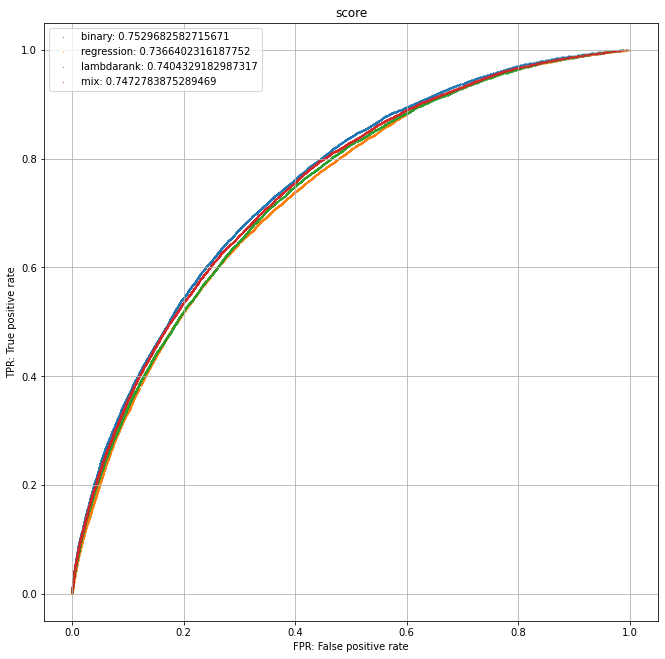

In [117]:
fig, ax = plt.subplots(figsize=(11, 11))
mix = (lgb_clf_binary.predict_proba(X_test.drop(['odds'], axis=1))[:, 1] + lgb_clf_regression.predict(X_test.drop(['odds'], axis=1)) + lgb_clf_lambdarank.predict(X_test.drop(['odds'], axis=1))) / 3
fpr1, tpr1, thresholds = roc_curve(y_test['rank_binary'], lgb_clf_binary.predict_proba(X_test.drop(['odds'], axis=1))[:, 1])
fpr2, tpr2, thresholds = roc_curve(y_test['rank_binary'], lgb_clf_regression.predict(X_test.drop(['odds'], axis=1)))
fpr3, tpr3, thresholds = roc_curve(y_test['rank_binary'], lgb_clf_lambdarank.predict(X_test.drop(['odds'], axis=1)))
fpr4, tpr4, thresholds = roc_curve(y_test['rank_binary'], mix)
ax.scatter(fpr1, tpr1, marker='o', s=0.1, label='binary: {}'.format(roc_auc_score(y_test['rank_binary'], lgb_clf_binary.predict_proba(X_test.drop(['odds'], axis=1))[:, 1])))
ax.scatter(fpr2, tpr2, marker='o', s=0.1, label='regression: {}'.format(roc_auc_score(y_test['rank_binary'], lgb_clf_regression.predict(X_test.drop(['odds'], axis=1)))))
ax.scatter(fpr3, tpr3, marker='o', s=0.1, label='lambdarank: {}'.format(roc_auc_score(y_test['rank_binary'], lgb_clf_lambdarank.predict(X_test.drop(['odds'], axis=1)))))
ax.scatter(fpr4, tpr4, marker='o', s=0.1, label='mix: {}'.format(roc_auc_score(y_test['rank_binary'], mix)))
ax.set_title('score')
ax.set_xlabel('FPR: False positive rate')
ax.set_ylabel('TPR: True positive rate')
ax.grid()
ax.legend()

In [118]:
# ModelEvaluator
me_binary = ModelEvaluator(lgb_clf_binary, return_tables_path=['../_dat/train_data/overall/return_tables.pickle'], kind=1, obj='binary')
# display(me_binary.feature_importance(X_test.drop(['odds'], axis=1), n_display=30, type='gain'))

me_regression = ModelEvaluator(lgb_clf_regression, return_tables_path=['../_dat/train_data/overall/return_tables.pickle'], kind=1, obj='regression')
# display(me_regression.feature_importance(X_test.drop(['odds'], axis=1), n_display=60, type='split'))

me_lambdarank = ModelEvaluator(lgb_clf_lambdarank, return_tables_path=['../_dat/train_data/overall/return_tables.pickle'], kind=0, obj='lambdarank')
# display(me_lambdarank.feature_importance(X_test.drop(['odds'], axis=1), n_display=30, type='gain'))

In [207]:
fukusho_df = pd.DataFrame({'score': lgb_clf_regression.predict(X_test.drop(['odds'], axis=1)), 'correct': y_test['rank_binary']})
fukusho_odds_df = pd.DataFrame([], columns=['odds'])
for threshold in np.arange(1, 2.5, 0.1):
    threshold = round(threshold, 1)
    temp = fukusho_df.copy()
    if threshold != 1:
        temp = temp[threshold < temp['score']]
    elif threshold != 2.4:
        temp = temp[temp['score'] < threshold+0.1]
    if threshold == 1: row_name = ' ~ 1.1'
    elif threshold == 2.4: row_name = '2.4 ~ '
    else: row_name = '{} ~ {}'.format(threshold, round(threshold+0.1, 1))
    fukusho_odds_df.loc[row_name] = [len(temp)/len(temp[temp['correct']==1])]
fukusho_odds_df

,odds
~ 1.1,13.959068
1.1 ~ 1.2,3.490571
1.2 ~ 1.3,3.241842
1.3 ~ 1.4,3.033996
1.4 ~ 1.5,2.843075
1.5 ~ 1.6,2.657389
1.6 ~ 1.7,2.479418
1.7 ~ 1.8,2.299588
1.8 ~ 1.9,2.135632
1.9 ~ 2.0,1.984075


In [18]:
original_race_card.preprocessing()
g_tansho_binary = m.gain(model_evaluator.tansho_return)

  0%|          | 0/100 [00:05<?, ?it/s]


ValueError: Number of features of the model must match the input. Model n_features_ is 52 and input n_features is 51

In [ ]:
g_tansho_binary = m.gain(me_binary.tansho_return, X_test)
g_tansho_regression = m.gain(me_regression.tansho_return, X_test)
g_tansho_lambdarank = m.gain(me_lambdarank.tansho_return, X_test)
# g_proper = m.gain(me.tansho_return_proper, X_test)
# g_umaren = m.gain(me_binary.umaren_box, X_test)
# g_sanrenpuku = m.gain(me_binary.sanrenpuku_box, X_test)
# g_fukusho = m.gain(me.fukusho_return, X_test)

 92%|█████████▏| 92/100 [05:22<00:20,  2.52s/it]/Users/naoki/.pyenv/versions/3.10.1/envs/Horse/lib/python3.10/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/naoki/.pyenv/versions/3.10.1/envs/Horse/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/naoki/.pyenv/versions/3.10.1/envs/Horse/lib/python3.10/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/naoki/git/Horse-Racing/Notebook/../module/_class/ModelEvaluator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  return_rate = np.sum(return_list) / n_bets
 92%|█████████▏| 92/100 [05:25<00:28,  3.54s/it]


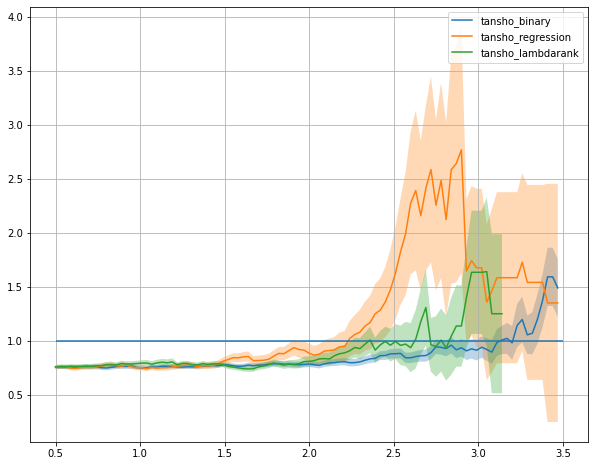

In [ ]:
plt.figure(figsize=(10, 8))
m.plot(g_tansho_binary, 'tansho_binary')
m.plot(g_tansho_regression, 'tansho_regression')
m.plot(g_tansho_lambdarank, 'tansho_lambdarank')
# m.plot(g_proper, 'proper')
# m.plot(g_umaren, 'umaren')
# m.plot(g_sanrenpuku, 'sanrenpuku')
# m.plot(g_proper, 'proper')
# m.plot(g_fukusho, 'fukusho')
plt.hlines(1, xmin=0.5, xmax=3.5) # y=1の直線

In [59]:
# # ModelEvaluator
# me = ModelEvaluator(lgb_clf, return_tables_path=['../_dat/pickle/overall/return_tables.pickle'], kind = 0)
# me.predict_proba(X_test)
# display(me.feature_importance(X_test.drop(['odds'], axis=1), n_display=20))

In [60]:
# g_proper = m.gain(me.tansho_return_proper, X_test)
# g_tansho = m.gain(me.tansho_return, X_test)
# g_fukusho = m.gain(me.fukusho_return, X_test)
# g_umatan = m.gain(me.umatan_box, X_test)
# g_umaren = m.gain(me.umaren_box, X_test)
# g_wide = m.gain(me.wide_box, X_test)
# g_sanrentan = m.gain(me.sanrentan_box, X_test)
# g_sanrenpuku = m.gain(me.sanrenpuku_box, X_test)
# g_umaren_nagashi = m.gain(me.umaren_nagashi, X_test)
# g_umatan_nagashi = m.gain(me.umatan_nagashi, X_test)
# g_wide_nagashi = m.gain(me.wide_nagashi, X_test)
# g_sanrentan_nagashi = m.gain(me.sanrentan_nagashi, X_test)

In [61]:
# plt.figure(figsize=(10, 8))
# m.plot(g_proper, 'proper')
# m.plot(g_tansho, 'tansho')
# m.plot(g_fukusho, 'fukusho')
# plt.hlines(1, xmin=0.5, xmax=3.5) # y=1の直線

In [62]:
# plt.figure(figsize=(10, 8))
# m.plot(g_umatan, 'umatan')
# m.plot(g_umaren, 'umaren')
# m.plot(g_wide, 'wide')
# plt.hlines(1, xmin=0.5, xmax=2.5) # y=1の直線

In [63]:
# plt.figure(figsize=(10, 8))
# m.plot(g_sanrentan, 'sanrentan')
# m.plot(g_sanrenpuku, 'sanrenpuku')
# plt.hlines(1, xmin=0.5, xmax=2.0) # y=1の直線

In [64]:
# plt.figure(figsize=(10, 8))
# m.plot(g_umatan_nagashi, 'umatan_nagashi')
# m.plot(g_umaren_nagashi, 'umaren_nagashi')
# m.plot(g_wide_nagashi, 'wide_nagashi')
# plt.hlines(1, xmin=0.5, xmax=3.5) # y=1の直線

In [65]:
# plt.figure(figsize=(10, 8))
# m.plot(g_sanrentan_nagashi, 'sanrentan_nagashi')
# plt.hlines(1, xmin=0.5, xmax=2.5) # y=1の直線

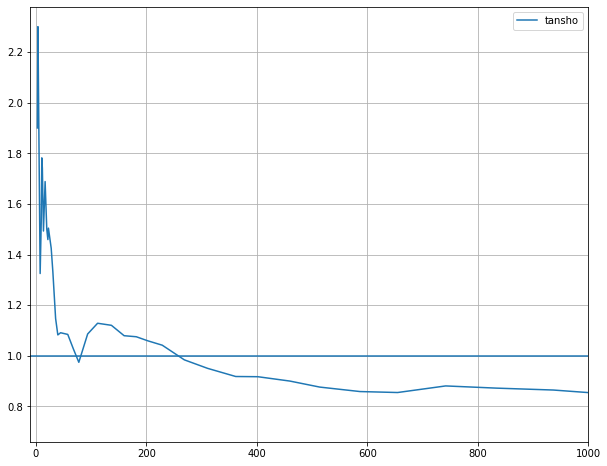

In [40]:
# 横軸: 賭け枚数
# 縦軸: 回収率
# 賭け枚数が少ない→一つの当たりの影響が大きい→賭け枚数が多いところでの期待値も＋になることが理想。

plt.figure(figsize=(10, 8))
plt.plot(g_tansho['n_bets'], g_tansho['return_rate'], label='tansho')
# plt.plot(g_proper['n_bets'], g_proper['return_rate'], label='proper')
# plt.plot(g_fukusho['n_bets'], g_fukusho['return_rate'], label='fukusho')
# plt.plot(g_umaren['n_bets'], g_umaren['return_rate'], label='umaren')
# plt.plot(g_umatan['n_bets'], g_umatan['return_rate'], label='umatan')
# plt.plot(g_wide['n_bets'], g_wide['return_rate'], label='wide')
# plt.plot(g_sanrentan['n_bets'], g_sanrentan['return_rate'], label='sanrentan')
# plt.plot(g_sanrenpuku['n_bets'], g_sanrenpuku['return_rate'], label='sarenpuku')
plt.hlines(1, xmin=-10, xmax=100000) # y=1の直線
plt.xlim(-10, 1000)
plt.legend()
plt.grid(True)

In [ ]:
# # 横軸: 賭け枚数
# # 縦軸: 回収率

# plt.figure(figsize=(10, 8))
# plt.plot(g_umaren_nagashi['n_bets'], g_umaren_nagashi['return_rate'], label='umaren_nagashi')
# plt.plot(g_umatan_nagashi['n_bets'], g_umatan_nagashi['return_rate'], label='umatan_nagashi')
# plt.plot(g_wide_nagashi['n_bets'], g_wide_nagashi['return_rate'], label='wide_nagashi')
# plt.plot(g_sanrentan_nagashi['n_bets'], g_sanrentan_nagashi['return_rate'], label='sanrentan_nagashi')
# plt.hlines(1, xmin=-10, xmax=2000) # y=1の直線
# plt.xlim(-10, 2000)
# plt.legend()
# plt.grid(True)

In [ ]:
# # シャープレシオ

# plt.figure(figsize=(10, 8))
# plt.plot(g_proper['n_bets'], (g_proper['return_rate'] - 1) / g_proper['std'], label='proper')
# plt.plot(g_tansho['n_bets'], (g_tansho['return_rate'] - 1) / g_tansho['std'], label='tansho')
# plt.plot(g_umaren['n_bets'], (g_umaren['return_rate'] - 1) / g_umaren['std'], label='umaren')
# # plt.plot(g_umatan['n_bets'], (g_umatan['return_rate'] - 1) / g_umatan['std'], label='umatan')
# # plt.plot(g_wide['n_bets'], (g_wide['return_rate'] - 1) / g_wide['std'], label='wide')
# # plt.plot(g_sanrentan['n_bets'], (g_sanrentan['return_rate'] - 1) / g_sanrentan['std'], label='sanrentan')
# plt.plot(g_sanrenpuku['n_bets'], (g_sanrenpuku['return_rate'] - 1) / g_sanrenpuku['std'], label='sanrenpuku')
# plt.xlim(-10, 200)
# plt.ylim(-10, 5)
# plt.legend()
# plt.grid()

In [ ]:
# # シャープレシオ

# plt.figure(figsize=(10, 8))
# plt.plot(g_umaren_nagashi['n_bets'], (g_umaren_nagashi['return_rate'] - 1) / g_umaren_nagashi['std'], label='umaren_nagashi')
# plt.plot(g_umatan_nagashi['n_bets'], (g_umatan_nagashi['return_rate'] - 1) / g_umatan_nagashi['std'], label='umatan_nagashi')
# plt.plot(g_wide_nagashi['n_bets'], (g_wide_nagashi['return_rate'] - 1) / g_wide_nagashi['std'], label='wide_nagashi')
# plt.plot(g_sanrentan_nagashi['n_bets'], (g_sanrentan_nagashi['return_rate'] - 1) / g_sanrentan_nagashi['std'], label='sanrentan_nagashi')
# plt.xlim(-10, 2000)
# plt.ylim(-10, 5)
# plt.legend()
# plt.grid()